# Uniswap V2 Math Tutorial

In this tutorial, we review the following:
* Swap
* Double-sided withdraw
* Double-sided deposit
* Single-sided withdraw
* Single-sided deposit

In [1]:
from uniswappy import *
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
user_nm = 'user_intro'
eth_amount = 1000
dai_amount = 1000000

## (1) Swap derivation 

In [3]:
dai = ERC20("DAI", "0x111")
eth = ERC20("ETH", "0x09")
exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = dai, symbol="LP", address="0x011")

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, eth_amount, dai_amount)
lp.summary()

Exchange ETH-DAI (LP)
Reserves: ETH = 1000.0, DAI = 1000000.0
Liquidity: 31622.776601683792 



In [4]:
out = Swap().apply(lp, eth, user_nm, 1)
lp.summary()

print(f'We receive {out:.5f} DAI for {1} ETH')

Exchange ETH-DAI (LP)
Reserves: ETH = 1001.0, DAI = 999003.9930189601
Liquidity: 31622.776601683792 

We receive 996.00698 DAI for 1 ETH


Given CPT formula 
> $ xy = L^2 $
>

with 0.3% swap fee
>   $\gamma = 1 - 0.003 = \frac{997}{1000}$
>
Swap CPT formula with fee
> (Eq.1)  $ \quad (x - \Delta x)(y + \gamma \Delta y) = xy$
>
To determine swap amount, isolate $\Delta x$
> (Eq.2)  $ \quad \Delta x = x - \frac{xy}{y + \gamma \Delta y}$
>
After performing some additional algebra, we get
> (Eq.3) $ \quad \Delta x = \frac{\gamma x\Delta y}{y + \gamma \Delta y}$

### Perform swap using dervation

In [5]:
dy = 1000
gamma = 997/1000
x = lp.get_reserve(eth)
y = lp.get_reserve(dai)

dx = (gamma*x*dy)/(y + gamma*dy)

print(f'We receive {dx:.5f} ETH for {dy} DAI')

We receive 0.99800 ETH for 1000 DAI


### Perform swap using uniswappy

In [6]:
out = Swap().apply(lp, dai, user_nm, dy)
lp.summary()

print(f'We receive {out:.5f} ETH for {dy} DAI')

Exchange ETH-DAI (LP)
Reserves: ETH = 1000.0020039910289, DAI = 1000003.9930189601
Liquidity: 31622.776601683792 

We receive 0.99800 ETH for 1000 DAI


(992000.0, 1008000.0)

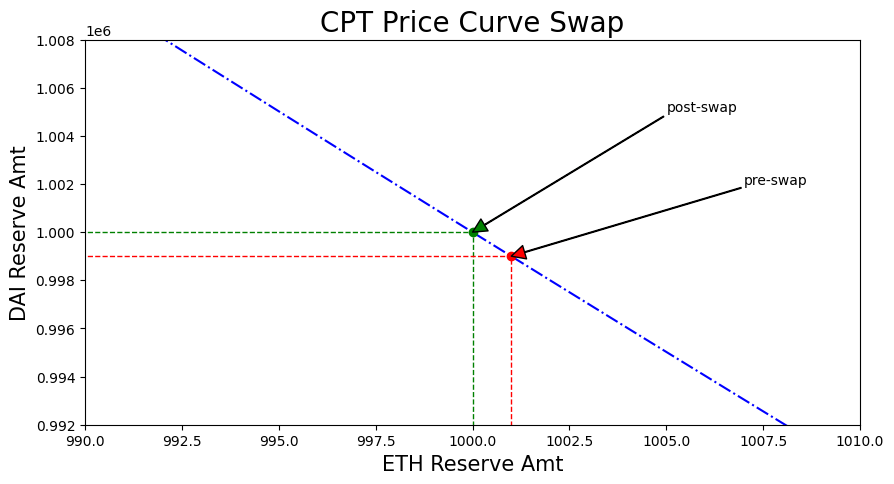

In [7]:
L = lp.get_liquidity()
x2 = lp.get_reserve(eth)
y2 = lp.get_reserve(dai)

x_arr = np.arange(990, 1010, 0.01)
y_arr = L**2/x_arr

fig, (ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(10, 5))
ax.plot(x_arr, y_arr, color = 'b',linestyle = 'dashdot', label='initial invest')
ax.plot(x, y, 'ro', color='r')
ax.plot(x2, y2, 'ro', color='g')

ax.hlines(y=y2, xmin=0, xmax=x2, linewidth=1, color='g', linestyle = 'dashed')
ax.vlines(x = x2, ymin=0, ymax=y2, linewidth=1, color='g', linestyle = 'dashed')

ax.hlines(y= y, xmin=0, xmax=x, linewidth=1, color='r', linestyle = 'dashed')
ax.vlines(x = x, ymin=0, ymax=y, linewidth=1, color='r', linestyle = 'dashed')

ax.annotate('post-swap', xy=(x2, y2),xytext=(x2+5, y2+5000), arrowprops=dict(facecolor='green',width=0.5,headwidth=10,headlength=10))
ax.annotate('pre-swap', xy=(x, y),xytext=(x2+7, y2+2000), arrowprops=dict(facecolor='red',width=0.5,headwidth=10,headlength=10))

ax.set_title(f'CPT Price Curve Swap', fontsize=20)
ax.set_ylabel(f'{dai.token_name} Reserve Amt', size=15)
ax.set_xlabel(f'{eth.token_name} Reserve Amt', size=15)
ax.set_xlim((990,1010))
ax.set_ylim((992000,1008000))

## (2) Doubled-sided withdraw derivation 

In [8]:
dai = ERC20("DAI", "0x111")
eth = ERC20("ETH", "0x09")
exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = dai, symbol="LP", address="0x011")

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, eth_amount, dai_amount)
lp.summary()

Exchange ETH-DAI (LP)
Reserves: ETH = 1000.0, DAI = 1000000.0
Liquidity: 31622.776601683792 



In [9]:
dx = 1
x = lp.get_reserve(eth)
y = lp.get_reserve(dai)
L = lp.get_liquidity()

Given CPT formula 
> $ xy = L^2 $
>

Price is determined as such
> $P = \frac{y}{x} = \frac{\Delta y}{\Delta x}$
>
> 
> $P = \frac{y}{x} = \frac{y^2}{xy} = \frac{y^2}{L^2}$, $\quad P = \frac{y}{x} = \frac{xy}{x^2} = \frac{L^2}{x^2}$
>  

Given P above, calculate $\Delta x$ and $\Delta y$ while maintaining price integrity

> $\sqrt{P} = \frac{y}{L}$, $\quad\quad\quad \sqrt{P} = \frac{L}{x}$
> 
> $\sqrt{\frac{\Delta y}{\Delta x}} = \frac{y}{L}$, $\quad\quad \sqrt{\frac{\Delta y}{\Delta x}} = \frac{L}{x}$
> 
> $\sqrt{\frac{\Delta y^2}{\Delta x \Delta y}} = \frac{y}{L}$, $\quad \sqrt{\frac{\Delta y \Delta x}{\Delta x^2}} = \frac{L}{x}$
>
> $\frac{\Delta y}{\Delta L} = \frac{y}{L}$, $\quad\quad\quad \frac{\Delta L}{\Delta x} = \frac{L}{x}$
>
> $\Delta y = \frac{y \Delta L}{L}$, $\quad\quad \Delta x = \frac{x \Delta L}{L}$
>

Take RHS of CPT formula and deduct $\Delta x$ and $\Delta y$ from both $x$ and $y$ to maintain integrity of the price 
> $ (x - \Delta x)(y - \Delta y) = (x - \frac{x \Delta L}{L})(y - \frac{y \Delta L}{L})$
>
> $\quad\quad\quad\quad\quad\quad\quad\quad = xy - 2xy\frac{\Delta L}{L} + xy\frac{\Delta L}{L} $
>  
> $\quad\quad\quad\quad\quad\quad\quad\quad = (L - \Delta L)^2$
>

CPT withdraw formula 
> $ (x - \Delta x)(y - \Delta y) = (L - \Delta L)^2 $

### Calculate withdraw using dervation

In [10]:
dL = dx*L/x
dy = y*dL/L
new_x = (x-dx)
new_y = (y-dy) 
new_L = L-dL

print(f'The updated reserves are {new_x} ETH and {new_y} DAI, and the updated liquidity is {new_L:8f}')

The updated reserves are 999.0 ETH and 999000.0 DAI, and the updated liquidity is 31591.153825


### Perform withdraw using uniswappy

In [11]:
RemoveLiquidity().apply(lp, eth, user_nm, dx)
lp.summary()

Exchange ETH-DAI (LP)
Reserves: ETH = 999.0, DAI = 999000.0
Liquidity: 31591.15382508211 



## (3) Doubled-sided deposit derivation 

In [12]:
dai = ERC20("DAI", "0x111")
eth = ERC20("ETH", "0x09")
exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = dai, symbol="LP", address="0x011")

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, eth_amount, dai_amount)
lp.summary()

Exchange ETH-DAI (LP)
Reserves: ETH = 1000.0, DAI = 1000000.0
Liquidity: 31622.776601683792 



In [13]:
dx = 1
x = lp.get_reserve(eth)
y = lp.get_reserve(dai)
L = lp.get_liquidity()

We know from above to maintain price integrity, double-sided change amounts $\Delta x$ and $\Delta y$ are determined as such
> $\Delta y = \frac{y \Delta L}{L}$, $\quad\quad \Delta x = \frac{x \Delta L}{L}$
>
Take RHS of CPT formula and add $\Delta x$ and $\Delta y$ to both $x$ and $y$ to maintain integrity of the price 
> $ (x + \Delta x)(y + \Delta y) = (x + \frac{x \Delta L}{L})(y + \frac{y \Delta L}{L})$
>

Perform algebra simular to above and we get the CPT deposit formula 
> $ (x + \Delta x)(y + \Delta y) = (L + \Delta L)^2 $

### Calculate deposit using derivation

In [14]:
dL = dx*L/x
dy = y*dL/L
new_x = (x+dx)
new_y = (y+dy) 
new_L = L+dL

print(f'The updated reserves are {new_x} ETH and {new_y} DAI, and the updated liquidity is {new_L:8f}')

The updated reserves are 1001.0 ETH and 1001000.0 DAI, and the updated liquidity is 31654.399378


### Perform deposit using uniswappy

In [15]:
AddLiquidity().apply(lp, eth, user_nm, dx)
lp.summary()

Exchange ETH-DAI (LP)
Reserves: ETH = 1001.0, DAI = 1001000.0
Liquidity: 31654.399378285478 



## (4) Single-sided withdraw derivation 

In [16]:
dai = ERC20("DAI", "0x111")
eth = ERC20("ETH", "0x09")
exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = dai, symbol="LP", address="0x011")

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, eth_amount, dai_amount)
lp.summary()

Exchange ETH-DAI (LP)
Reserves: ETH = 1000.0, DAI = 1000000.0
Liquidity: 31622.776601683792 



Given $\Delta x$ and $\Delta y$ for withdraw
> $\Delta y = \frac{y \Delta L}{L}$, $\quad\quad \Delta x = \frac{x \Delta L}{L}$
>
Also, given swap equation
> $ \Delta y_{s} = \frac{\gamma y\Delta x}{x + \gamma \Delta x}$
>
A single-sided withdraw constitutes of the sum total of a withdraw and a swap, otherwise known as a WithdrawSwap, and is given by
> $ \Delta y_{ws} = \Delta y + \frac{\gamma \Delta x (y - \Delta y)}{(x - \Delta x) + \gamma \Delta x}$
>
Plug $\Delta x$ and $\Delta y$ into $\Delta y_{ws}$ and after performing some algebra we get
> $\Delta L^2 \left( \frac{xy}{L^2}\right) + \Delta L \left( \frac{-\Delta y_{ws}x + \Delta y_{ssw} \gamma x -xy -xy\gamma}{L}  \right) + \Delta y_{ws}x = 0$
>
Given the fact we know our desired withdraw amount, $\Delta y_{ws}$, we solve the above quadratic to determine our single-sided settlement amount in terms of $\Delta L$

### Perform single-sided withdraw using uniswappy

In [17]:
dy = 1
amount_out = WithdrawSwap().apply(lp, eth, user_nm, dy)
lp.summary()

Exchange ETH-DAI (LP)
Reserves: ETH = 999.0, DAI = 1000000.0
Liquidity: 31606.937511796754 



## (5) Single-sided deposit derivation 

In [18]:
dai = ERC20("DAI", "0x111")
eth = ERC20("ETH", "0x09")
exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = dai, symbol="LP", address="0x011")

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, eth_amount, dai_amount)
lp.summary()

Exchange ETH-DAI (LP)
Reserves: ETH = 1000.0, DAI = 1000000.0
Liquidity: 31622.776601683792 



A single-sided deposit constitutes of the sum total of a swap followed by a deposit, otherwise known as a SwapDeposit, and is given by
> $ \Delta x_{sd} = \Delta x_{swap} + \Delta x_{deposit}$
> 
> $ \quad\quad       = \alpha \Delta x_{sd} + \frac{\Delta y_{s}(x+\alpha\Delta x_{sd})}{y - \Delta y_{s}}$
>
Given swap equation
> $ \Delta y_{s} = \frac{\gamma x\Delta y}{y + \gamma \Delta y}$

Thus, we get this system of equations:

> (Eq. 1) $ \Delta y_{s} = \frac{\gamma x\Delta y}{y + \gamma \Delta y}$

> (Eq. 2) $\Delta x_{sd} = \alpha\Delta x_{sd}   + \frac{\Delta y_{s}(x + \alpha\Delta x_{sd} )}{y - \Delta y_{s}}$

where $\gamma = \frac{997}{1000}$

To solve for ratio $\alpha$, we plug (1) into (2), and after some algebra, we get this quadratic 

> $\alpha^2 \frac{997 \Delta x_{sd}^2}{1000x} + \alpha\frac{1997\Delta x_{sd}}{1000} - \Delta x_{sd} = 0$

### Perform single-sided deposit using uniswappy

In [19]:
dy = 1
dep = SwapDeposit().apply(lp, eth, user_nm, dy)
lp.summary()

Exchange ETH-DAI (LP)
Reserves: ETH = 1001.0, DAI = 1000000.0
Liquidity: 31638.56029234534 

